In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

/tmp/ipykernel_2333/2011421623.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pip install librosa pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [6]:
!pwd

/root/3A/ProjetLong/OrthopteraStridulationClassifier/Notebooks/XgBoost


In [68]:
path_global_5s_train = "DataSet/NewDataSet5sec/train_audible_recording_chunks.csv"
path_global_5s_test = "DataSet/NewDataSet5sec/test_audible_recording_chunks.csv"
path_global_5s_val = "DataSet/NewDataSet5sec/val_audible_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_global_5s_train)
df_test = pd.read_csv(path_global_5s_test)
df_val = pd.read_csv(path_global_5s_val)

# df filtered with insects only
df_train_order = df_train[df_train["label_class"] == "Insecta"]
df_test_order = df_test[df_test["label_class"] == "Insecta"]
df_val_order = df_val[df_val["label_class"] == "Insecta"]

/tmp/ipykernel_456/978523696.py:15: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path_global_5s_train)


In [69]:
# Pre traitement des données pour les données de 5sec 
# récupération des fréquences min et max, ainsi de la durée de chaque stridulation des insectes 
def pretraitement_data(df) : 
    colonnes = ["label", "label_subfamily","min_frequency", "max_frequency", "duree", "avg_frequency"]
    new_df = pd.DataFrame(columns = colonnes)

    # Get a list of code_unique in the df 
    codes = df['code_unique'].unique().tolist()
    iter = 0 
    for code in tqdm(codes) : 
        df_inter = df[df['code_unique'] == code]
        l = len(df_inter)
        ind = list(df_inter.index)
        for i,row in df_inter.iterrows():
            # Si le chunk n'a pas été traité
            if i in ind : 
                label = row['label']
                label_sub = row['label_subfamily']
                start = row['annotation_initial_time']
                end = row['annotation_final_time']
                duree = end - start
                ind.remove(i)
                cond = True
                while cond : 
                    # Tant qu'on trouve un chunk qui va à la suite de celui-ci
                    cond = False
                    for j in ind : 
                        lab = df_inter.loc[j,'label']
                        if label == lab : 
                            new_start = df_inter.loc[j,'annotation_initial_time']
                            if end == new_start : 
                                new_end = df_inter.loc[j,'annotation_final_time']
                                duree += (new_end - new_start)
                                end = new_end
                                ind.remove(j)
                                cond= True
                                break
                
                new_df.at[iter,"label"] = label
                new_df.at[iter,"label_subfamily"] = label_sub
                new_df.at[iter, "duree"] = duree
                new_df.at[iter, "min_frequency"] = row['min_frequency']
                new_df.at[iter,"max_frequency"] = row['max_frequency']
                new_df.at[iter,"avg_frequency"] = row['avg_frequency']
                iter += 1 
        
    return new_df
                 

In [70]:
# Train data preprocessing
newdf_train = pretraitement_data(df_train_order)

100%|██████████| 1010/1010 [00:11<00:00, 90.94it/s]


In [71]:
# Test and val data preprocessing
newdf_test = pretraitement_data(df_test_order)
newdf_val = pretraitement_data(df_val_order)

100%|██████████| 126/126 [00:02<00:00, 59.62it/s]


In [72]:
newdf_train

,label,label_subfamily,min_frequency,max_frequency,duree,avg_frequency
0,Tettigonia viridissima,Tettigoniinae,7918.890625,11211.359375,211.0,1646.234375
1,Eumodicogryllus bordigalensis,Gryllinae,3322.279053,4818.990234,0.280188,748.35559
2,Eumodicogryllus bordigalensis,Gryllinae,3236.450195,4858.814941,1.761183,811.182373
3,Eumodicogryllus bordigalensis,Gryllinae,3236.450195,4939.322754,0.973987,851.436279
4,Eumodicogryllus bordigalensis,Gryllinae,3208.250244,5145.73584,8.152144,968.742798
...,...,...,...,...,...,...
4496,Chrysochraon dispar,Gomphocerinae,5416.521973,15401.109375,1.313309,4992.293701
4497,Chrysochraon dispar,Gomphocerinae,5416.521973,17367.482422,0.927041,5975.480225
4498,Chrysochraon dispar,Gomphocerinae,5007.94043,16160.583984,1.004295,5576.321777
4499,Chrysochraon dispar,Gomphocerinae,4750.82959,16553.648438,1.622322,5901.409424


In [73]:
# Label encoders for classifying labels and subfamily labels
label_encoder = LabelEncoder()
label_encoder.fit(newdf_train['label'])

label_encoder_subfamily = LabelEncoder()
label_encoder_subfamily.fit(newdf_train['label_subfamily'])

def clean_data(df):
    y = df['label']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_label_encoded = label_encoder.transform(y)
    y_subfamily_encoded = label_encoder_subfamily.transform(y_subfamily)
    
    #df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['max_frequency', 'min_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)
    df['duree'] = df['duree'].astype(int)

    # Gestion des valeurs manquantes
    df.fillna(df.mean(), inplace=True)
    df = df.dropna()

    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    return X, y_label_encoded, y_subfamily_encoded

X_train, y_train_label, y_train_sublabel = clean_data(newdf_train)
X_test, y_test_label, y_test_sublabel = clean_data(newdf_test)
X_val, y_val_label, y_val_sublabel = clean_data(newdf_val)

/tmp/ipykernel_456/263827324.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_frequency'] = df['min_frequency'].astype(int)
/tmp/ipykernel_456/263827324.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_frequency'] = df['max_frequency'].astype(int)
/tmp/ipykernel_456/263827324.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

RandomForest :
Result label classification: 0.3528114663726571
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.19      0.22      0.21        18
           2       0.00      0.00      0.00         1
           3       0.50      0.25      0.33         4
           4       0.08      0.11      0.10         9
           5       0.00      0.00      0.00         8
           6       0.37      0.57      0.44        46
           7       0.00      0.00      0.00         1
           8       0.14      0.07      0.09        15
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        14
          11       0.83      0.71      0.77         7
          12       0.00      0.00      0.00         2
          13       0.38      0.60      0.46         5
          14       0.00      0.00      0.00        31
          15       0.33      0.67      0.44         3
          16      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

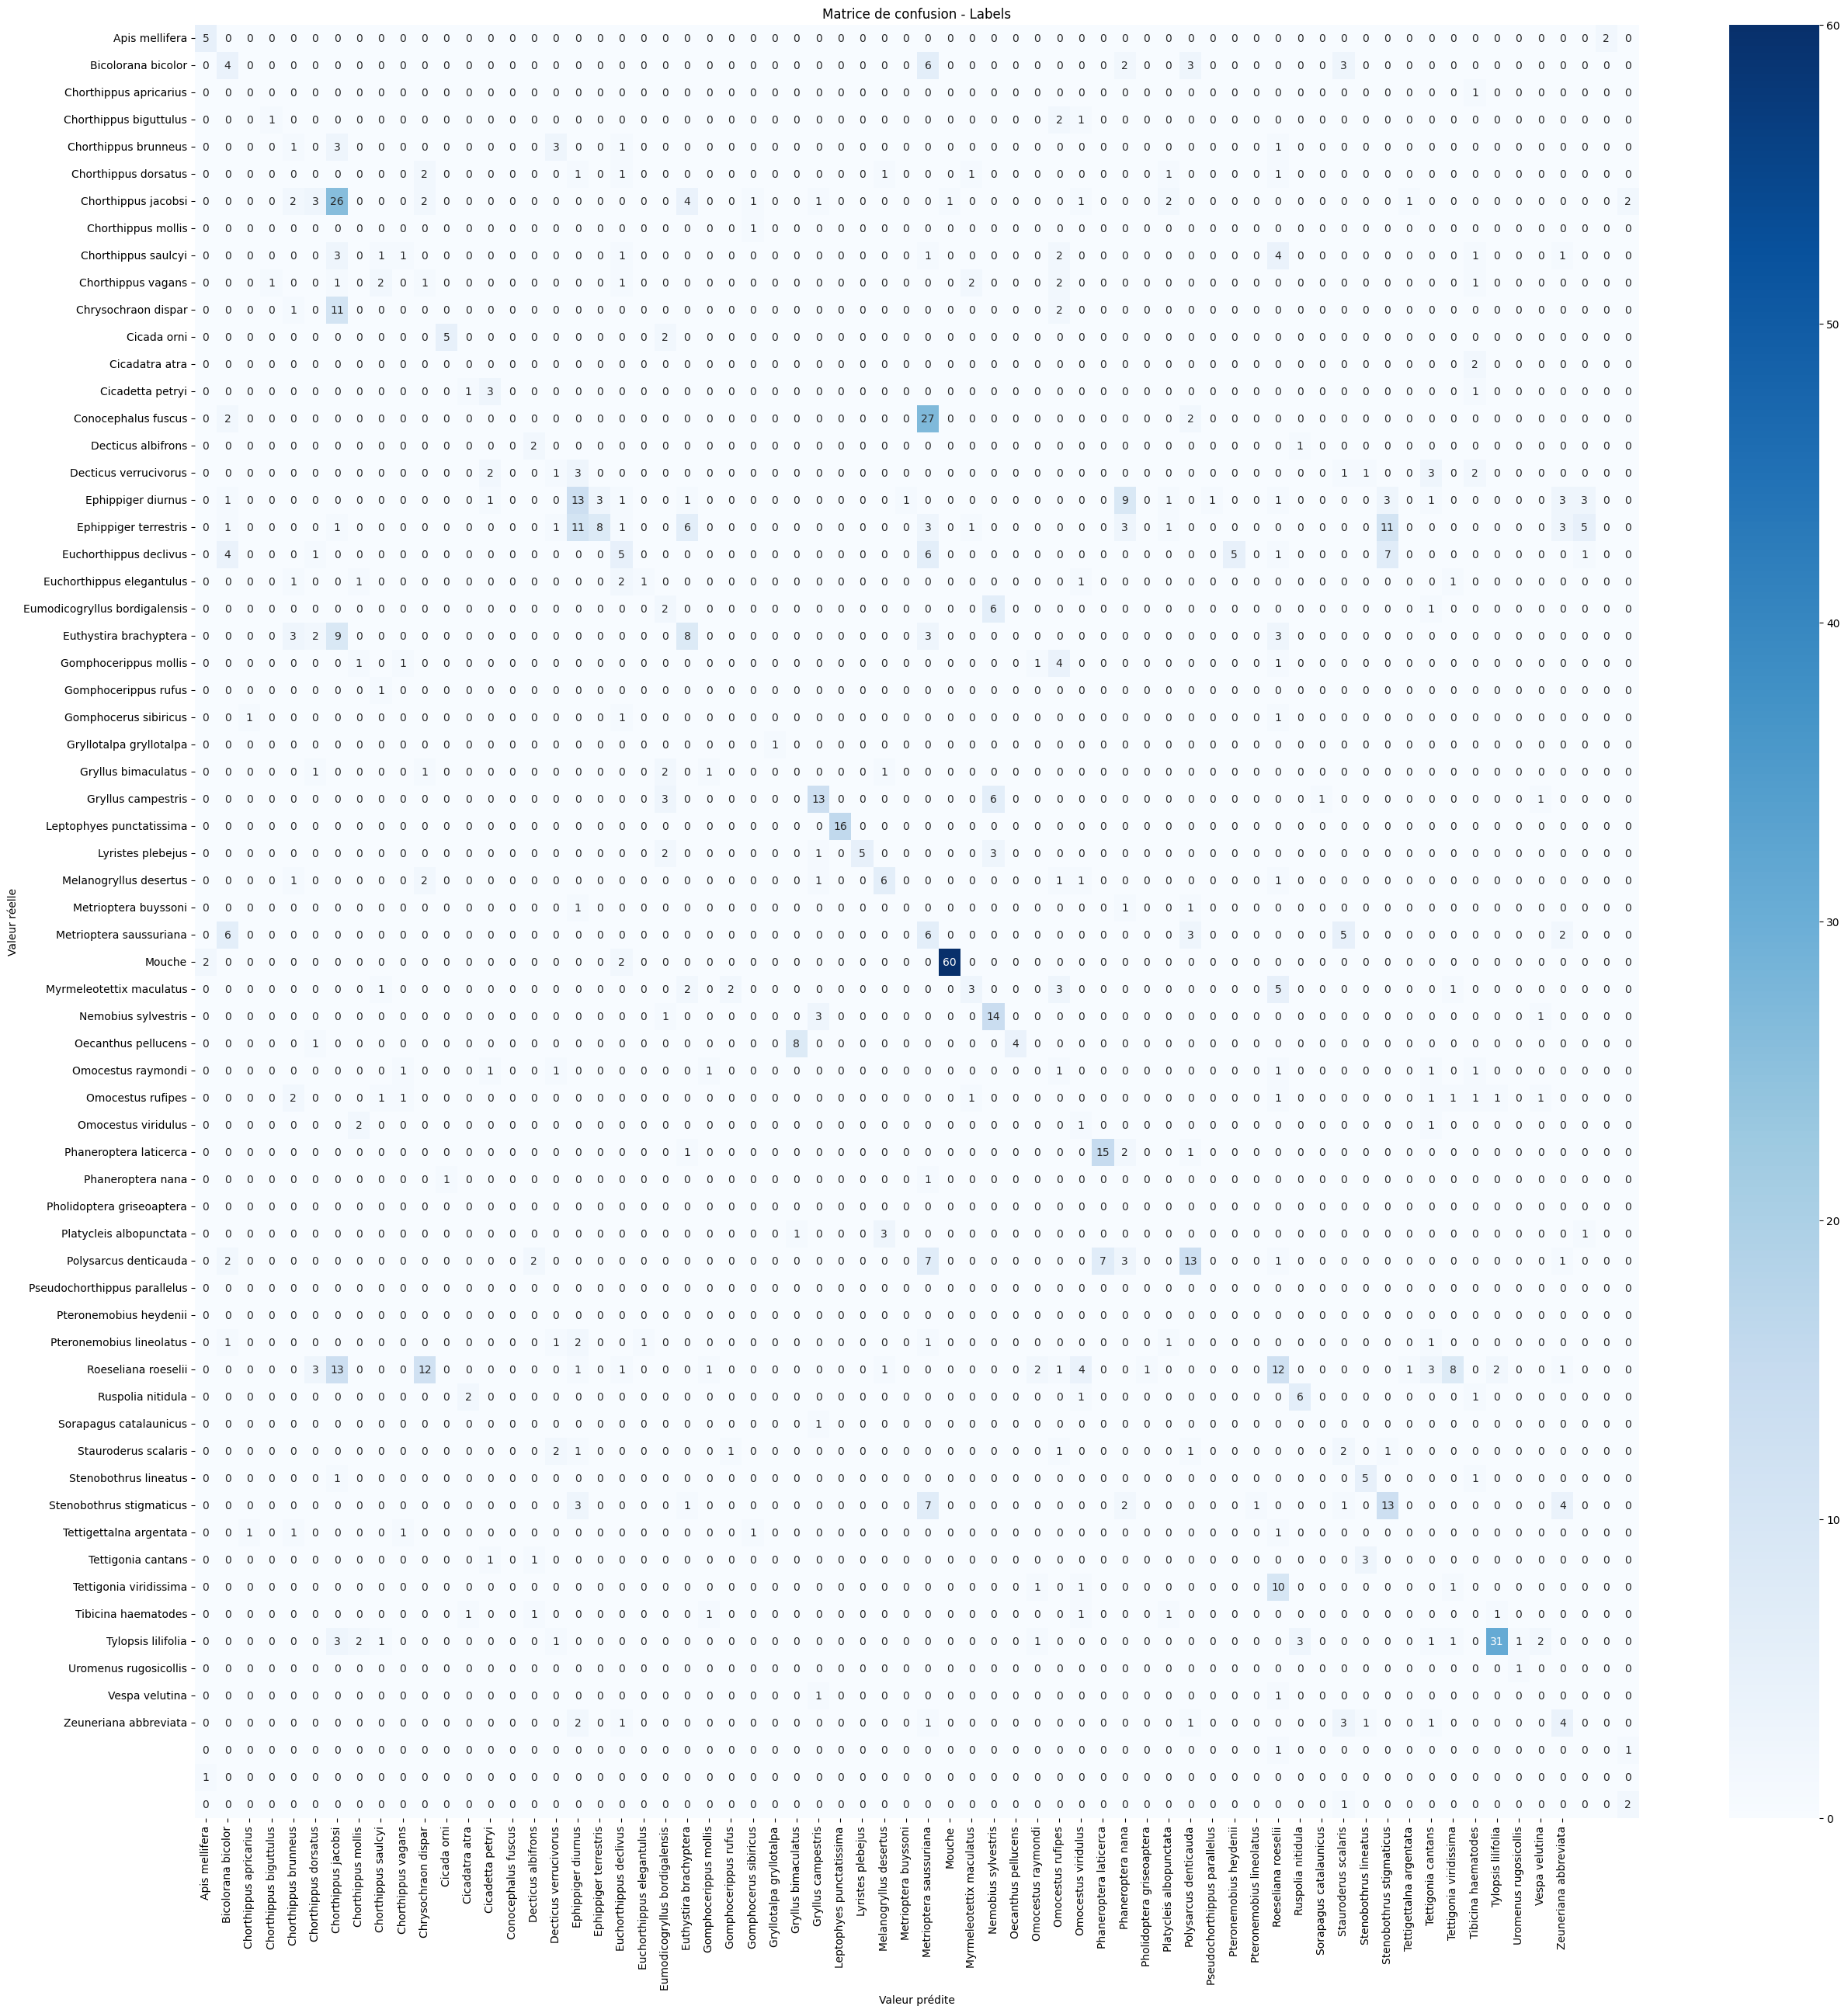

In [75]:
# # Random forest classifier for labels

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

rf_classifier.fit(X_train, y_train_label)

predictions_label = rf_classifier.predict(X_test)

# Model evaluation
print("RandomForest :")
print("Result label classification:", accuracy_score(y_test_label, predictions_label))
print(classification_report(y_test_label, predictions_label))

# Confusion matrix 
cm = confusion_matrix(y_test_label, predictions_label)
y_test_inversed = label_encoder.inverse_transform(y_test_label)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Labels')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

In [76]:
print(unique_labels)

['Apis mellifera' 'Bicolorana bicolor' 'Chorthippus apricarius'
 'Chorthippus biguttulus' 'Chorthippus brunneus' 'Chorthippus dorsatus'
 'Chorthippus jacobsi' 'Chorthippus mollis' 'Chorthippus saulcyi'
 'Chorthippus vagans' 'Chrysochraon dispar' 'Cicada orni' 'Cicadatra atra'
 'Cicadetta petryi' 'Conocephalus fuscus' 'Decticus albifrons'
 'Decticus verrucivorus' 'Ephippiger diurnus' 'Ephippiger terrestris'
 'Euchorthippus declivus' 'Euchorthippus elegantulus'
 'Eumodicogryllus bordigalensis' 'Euthystira brachyptera'
 'Gomphocerippus mollis' 'Gomphocerippus rufus' 'Gomphocerus sibiricus'
 'Gryllotalpa gryllotalpa' 'Gryllus bimaculatus' 'Gryllus campestris'
 'Leptophyes punctatissima' 'Lyristes plebejus' 'Melanogryllus desertus'
 'Metrioptera buyssoni' 'Metrioptera saussuriana' 'Mouche'
 'Myrmeleotettix maculatus' 'Nemobius sylvestris' 'Oecanthus pellucens'
 'Omocestus raymondi' 'Omocestus rufipes' 'Omocestus viridulus'
 'Phaneroptera laticerca' 'Phaneroptera nana' 'Pholidoptera griseoap

XGBoost:
Results label classification: 0.3274531422271224
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.05      0.06      0.05        18
           2       0.00      0.00      0.00         1
           3       0.50      0.25      0.33         4
           4       0.18      0.22      0.20         9
           5       0.00      0.00      0.00         8
           6       0.26      0.48      0.34        46
           7       0.00      0.00      0.00         1
           8       0.38      0.20      0.26        15
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        14
          11       0.67      0.57      0.62         7
          12       0.00      0.00      0.00         2
          13       0.50      0.60      0.55         5
          14       0.00      0.00      0.00        31
          15       0.33      0.67      0.44         3
          16       0.12

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

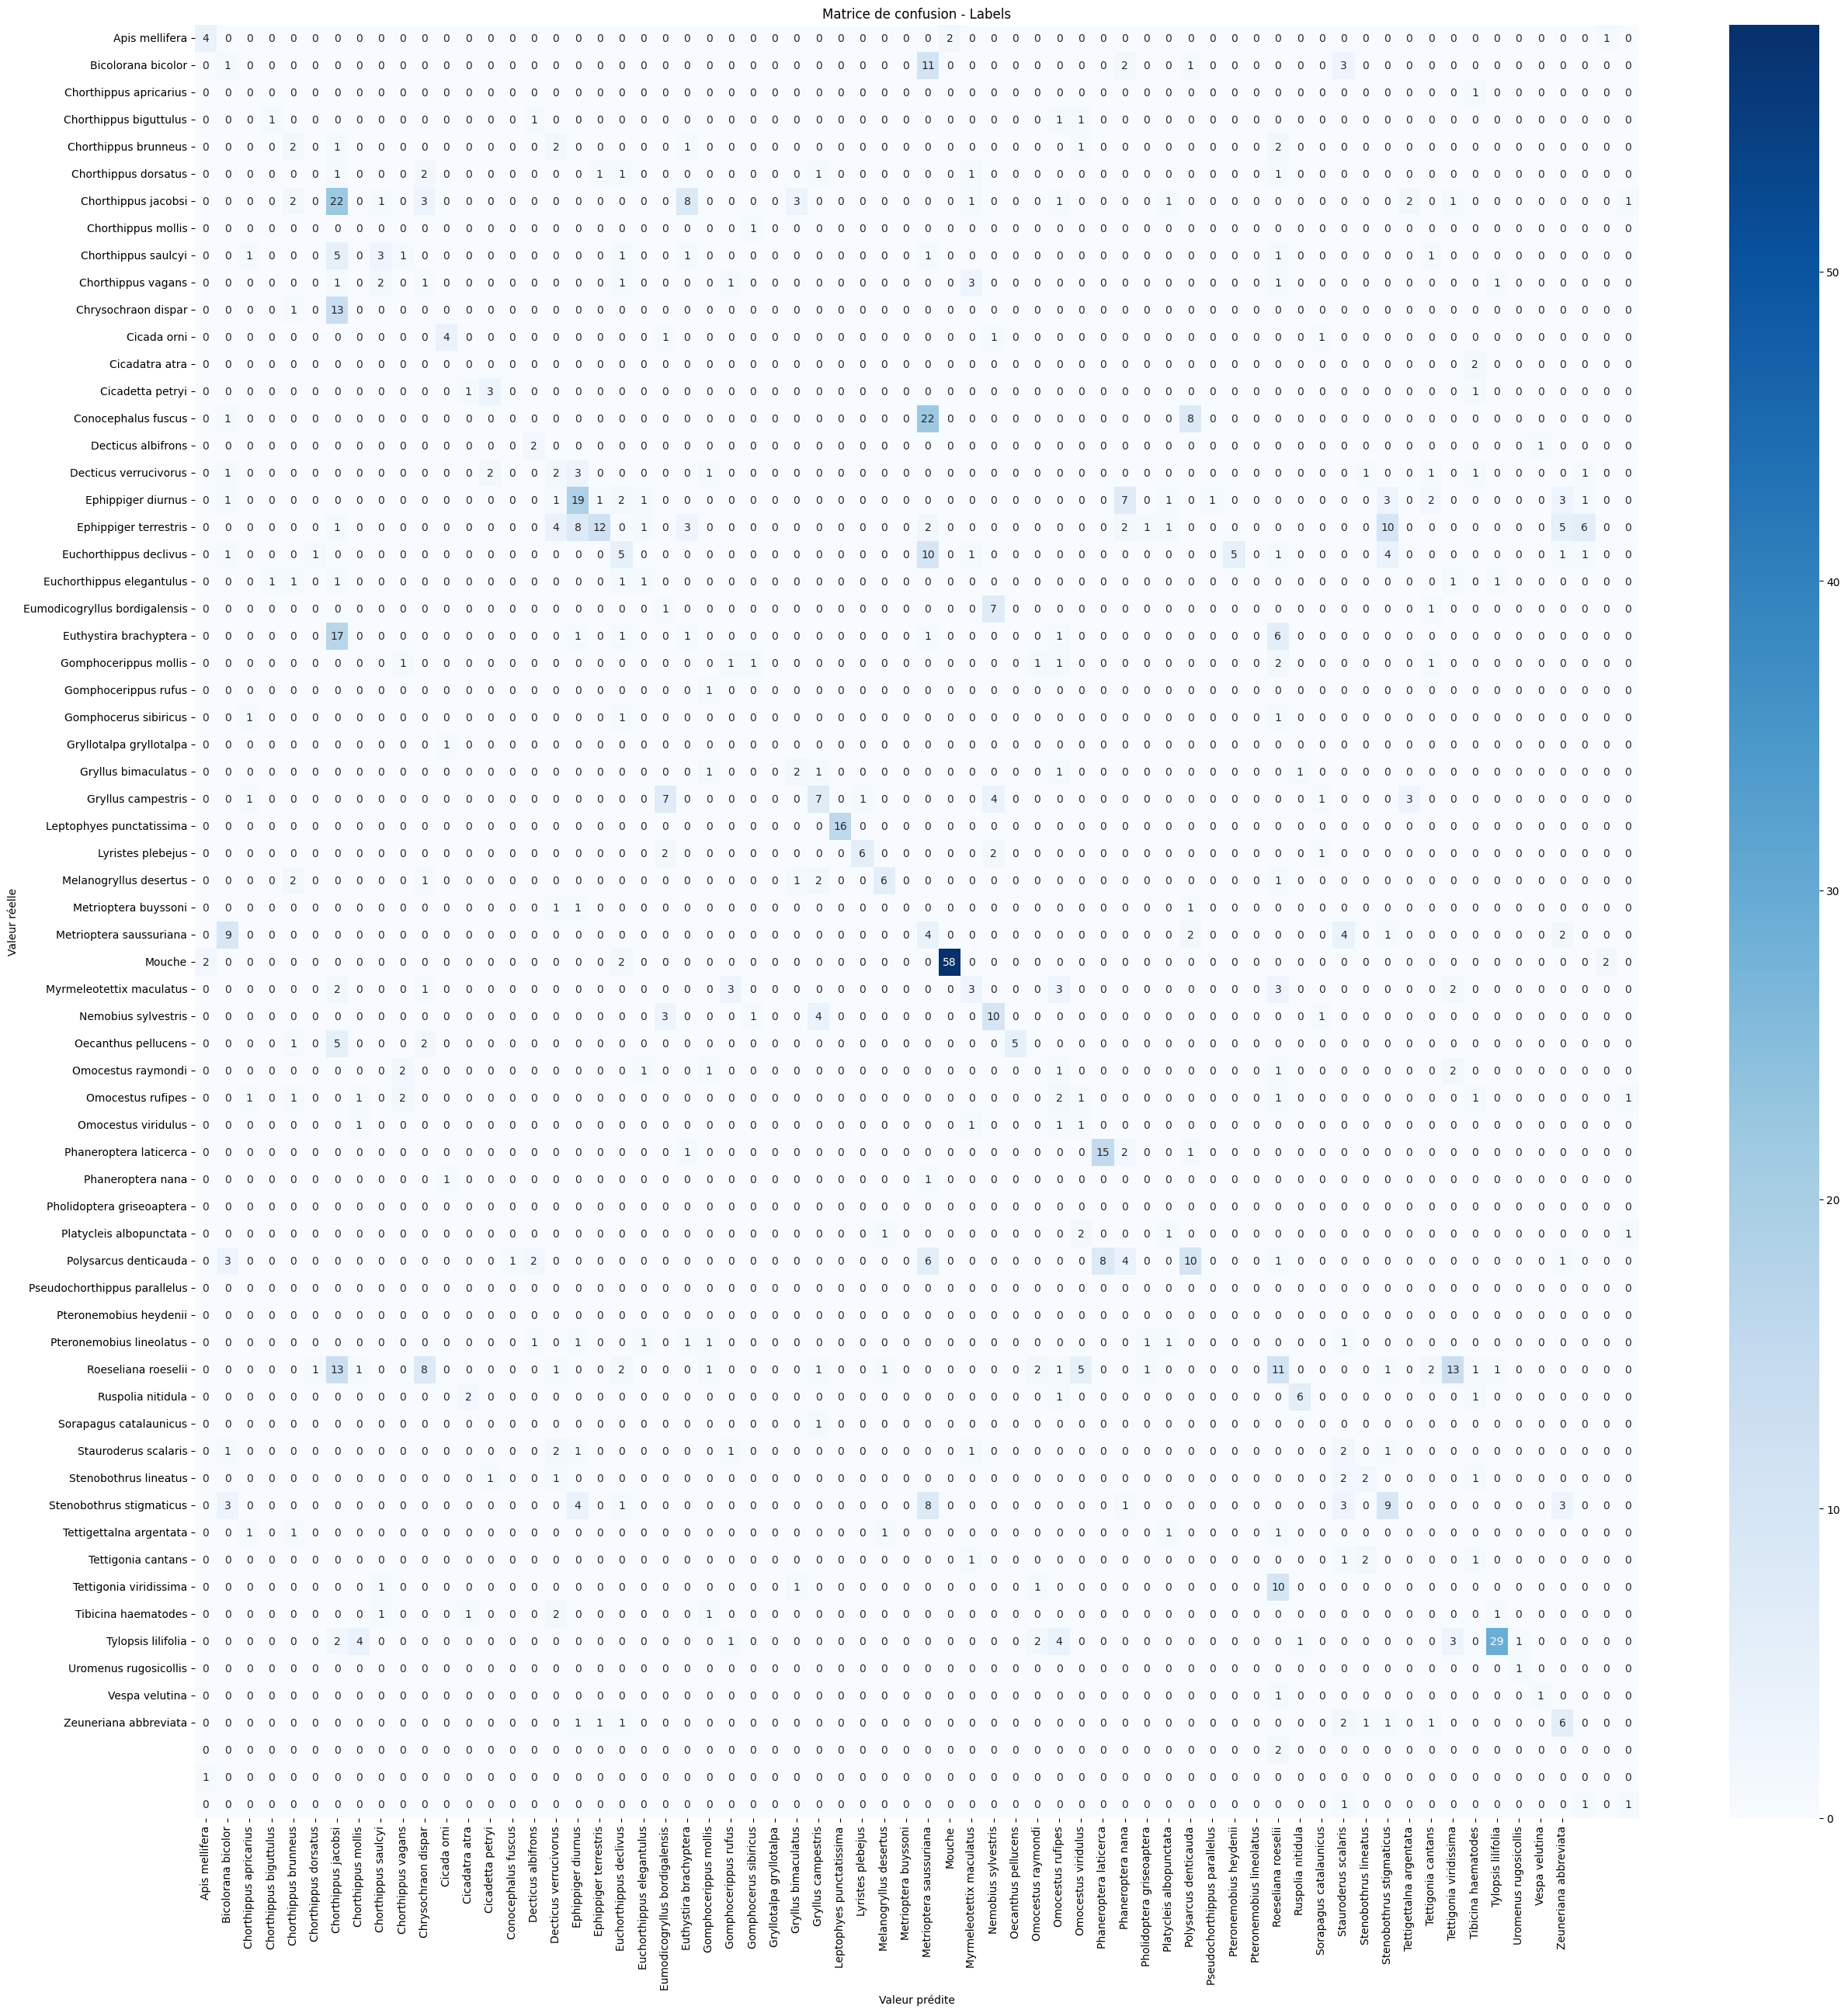

In [61]:
# XGBoost classifier for labels 

xgb_model = XGBClassifier()

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train_label)

predictions_label = xgb_model.predict(X_test)

# Model evaluation
print("XGBoost:")
print("Results label classification:", accuracy_score(y_test_label, predictions_label))
print(classification_report(y_test_label, predictions_label))

# Confusion matrix
cm = confusion_matrix(y_test_label, predictions_label)
y_test_inversed = label_encoder.inverse_transform(y_test_label)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Labels')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

XGBoost:
Results label classification: 0.6868798235942668
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.82      0.54      0.65       133
           2       0.33      0.45      0.38        11
           3       0.67      0.50      0.57        20
           4       0.38      0.08      0.13        38
           5       0.81      0.86      0.83       316
           6       0.61      0.60      0.60        52
           7       0.00      0.00      0.00         1
           8       0.51      0.60      0.55        30
           9       1.00      0.38      0.56        13
          10       0.52      0.66      0.58        59
          11       0.50      0.50      0.50         2
          12       0.50      0.66      0.57       160
          13       0.00      0.00      0.00         1
          14       0.97      0.94      0.95        64

    accuracy                           0.69       907
   macro avg       0.5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


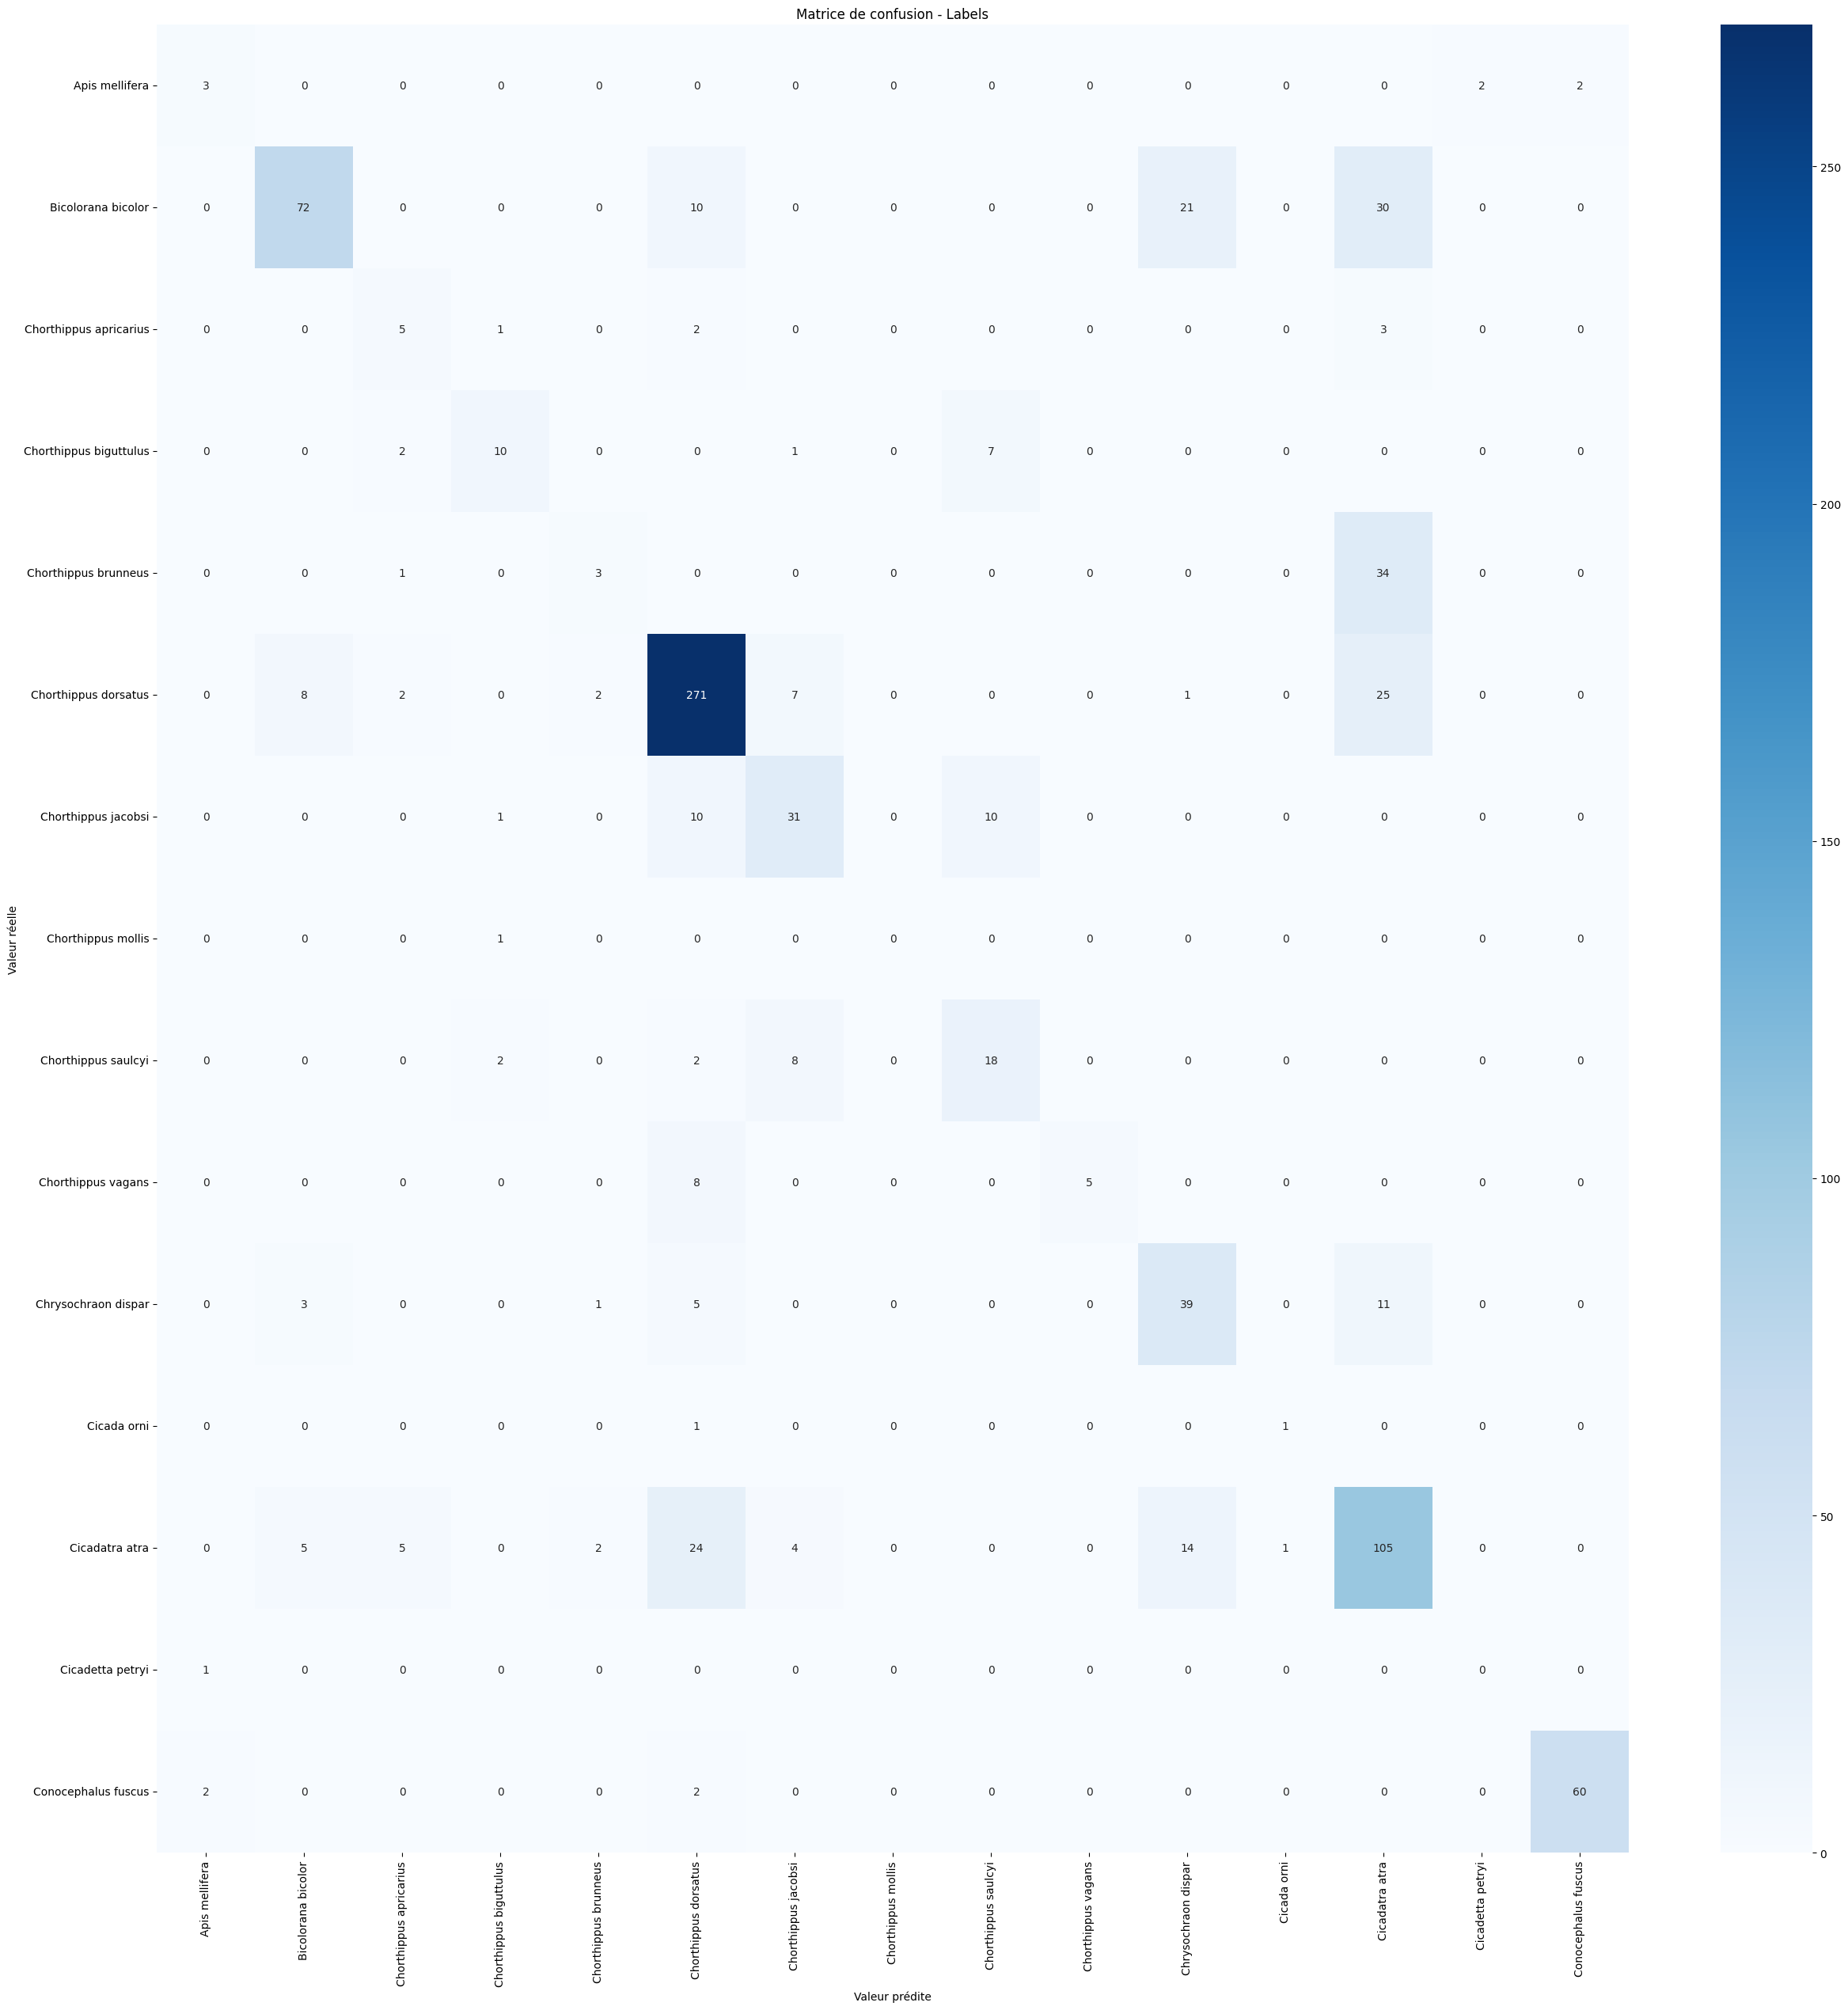

In [77]:
# XGBoost classifier for subfamily labels

xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train_sublabel)

predictions_label = xgb_model.predict(X_test)

# Model evaluation
print("XGBoost:")
print("Results label classification:", accuracy_score(y_test_sublabel, predictions_label))
print(classification_report(y_test_sublabel, predictions_label))

# Confusion matrix
cm = confusion_matrix(y_test_sublabel, predictions_label)
y_test_inversed = label_encoder.inverse_transform(y_test_sublabel)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Labels')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

In [52]:
print(unique_labels)

['Apis mellifera' 'Bicolorana bicolor' 'Chorthippus apricarius'
 'Chorthippus biguttulus' 'Chorthippus brunneus' 'Chorthippus dorsatus'
 'Chorthippus jacobsi' 'Chorthippus mollis' 'Chorthippus saulcyi'
 'Chorthippus vagans' 'Chrysochraon dispar' 'Cicada orni' 'Cicadatra atra'
 'Cicadetta petryi' 'Conocephalus fuscus' 'Decticus albifrons'
 'Decticus verrucivorus' 'Ephippiger diurnus' 'Ephippiger terrestris'
 'Euchorthippus declivus' 'Euchorthippus elegantulus'
 'Eumodicogryllus bordigalensis' 'Euthystira brachyptera'
 'Gomphocerippus mollis' 'Gomphocerippus rufus' 'Gomphocerus sibiricus'
 'Gryllotalpa gryllotalpa' 'Gryllus bimaculatus' 'Gryllus campestris'
 'Leptophyes punctatissima' 'Lyristes plebejus' 'Melanogryllus desertus'
 'Metrioptera buyssoni' 'Metrioptera saussuriana' 'Mouche'
 'Myrmeleotettix maculatus' 'Nemobius sylvestris' 'Oecanthus pellucens'
 'Omocestus raymondi' 'Omocestus rufipes' 'Omocestus viridulus'
 'Phaneroptera laticerca' 'Phaneroptera nana' 'Pholidoptera griseoap

In [57]:
# Random Forest classifier for subfamily labels
rf_classifier_subfamily = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

rf_classifier_subfamily.fit(X_train, y_train_sublabel)

predictions_sublabel = rf_classifier_subfamily.predict(X_test)

# Model evaluation
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test_sublabel, predictions_sublabel))
print(classification_report(y_test_sublabel, predictions_sublabel))

# Confusion matrix
cm = confusion_matrix(y_test_sublabel, predictions_sublabel)
y_test_inversed = label_encoder_subfamily.inverse_transform(y_test_sublabel)

unique_labels = np.unique(y_test_inversed)

plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion - Category')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.6824696802646086
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.80      0.53      0.64       133
           2       0.27      0.36      0.31        11
           3       0.71      0.50      0.59        20
           4       0.50      0.05      0.10        38
           5       0.79      0.86      0.82       316
           6       0.59      0.50      0.54        52
           7       1.00      1.00      1.00         1
           8       0.49      0.60      0.54        30
           9       1.00      0.31      0.47        13
          10       0.51      0.63      0.56        59
          11       1.00      0.50      0.67         2
          12       0.52      0.68      0.59       160
          13       0.00      0.00      0.00         1
          14       1.00      0.94      0.97        64

    accuracy                           0.68       907


IndexError: arrays used as indices must be of integer (or boolean) type